In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mstats
import matplotlib.pyplot as plt
import seaborn as sns
import pystan
%matplotlib inline

In [2]:
plt.style.use('ggplot')

In [3]:
data = pd.read_csv('./input/data-attendance-1.txt')

In [4]:
data.head()

,A,Score,Y
0,0,69,0.286
1,1,145,0.196
2,0,125,0.261
3,1,86,0.109
4,1,158,0.230


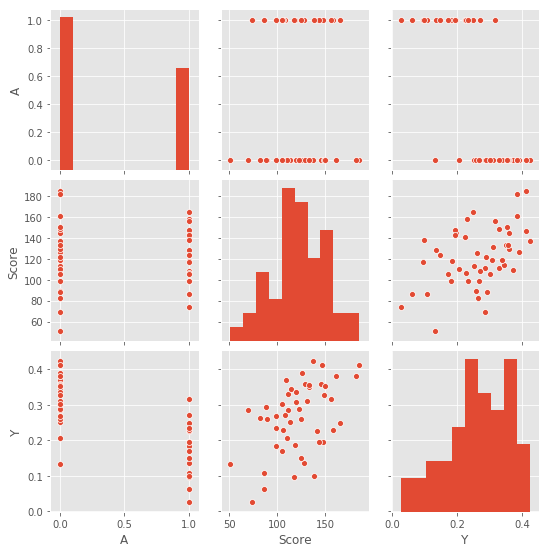

In [5]:
sns.pairplot(data)

In [6]:
stan_model = """

data{
  int N;
  int<lower=0, upper=1> A[N];
  real<lower=0> Score[N];
  real<lower=0, upper=1> Y[N];  
}

parameters {
  real b1;
  real b2;
  real b3;
  real<lower=0> sigma;
}

transformed parameters {
  real mu[N];
  for (n in 1:N){
    mu[n] = b1 + b2 * A[n] + b3 * Score[n];
  }
}

model {
  for (n in 1:N){
    Y[n] ~ normal(mu[n], sigma);
  }
}

generated quantities {
  real y_pred[N];
  for (n in 1:N){
    y_pred[n] = normal_rng(mu[n], sigma);
  }
}
"""

In [7]:
sm = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c34945e5f3a8533c2909da831a24de1a NOW.


In [8]:
stan_data = {}
stan_data['N'] = data.shape[0]
stan_data['A'] = data['A']
stan_data['Score'] = data['Score']/200
stan_data['Y'] = data['Y']

In [9]:
fit = sm.sampling(stan_data)

In [10]:
fit


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_c34945e5f3a8533c2909da831a24de1a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd    2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b1           0.12  7.7e-4   0.03    0.06    0.1   0.12   0.14   0.18   1727   1.01
b2          -0.14  3.0e-4   0.01   -0.17  -0.15  -0.14  -0.13  -0.11   2377    1.0
b3           0.33  1.2e-3   0.05    0.23   0.29   0.32   0.36   0.43   1722   1.01
sigma        0.05  1.1e-4 5.4e-3    0.04   0.05   0.05   0.05   0.06   2206    1.0
mu[1]        0.24  3.7e-4   0.02     0.2   0.22   0.24   0.25   0.27   1897   1.01
mu[2]        0.22  2.4e-4   0.01    0.19   0.21   0.22   0.22   0.24   2899    1.0
mu[3]        0.33  1.6e-4 9.3e-3    0.31   0.32   0.33   0.33   0.34   3260    1.0
mu[4]        0.12  3.0e-4   0.01    0.09   0.11   0.12   0.13   0.15   2482    1.0
mu[5]        0.24  2.9e-

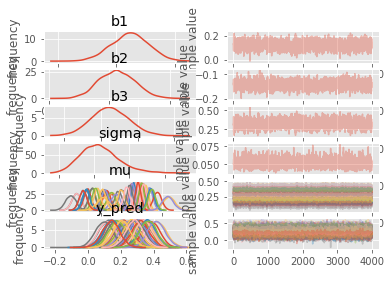

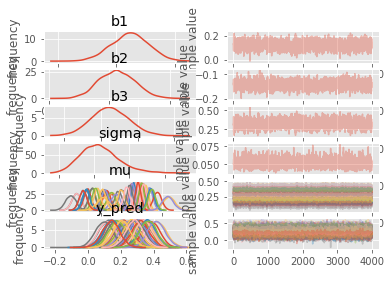

In [11]:
fit.plot()

In [12]:
sample_y_pred = fit.extract('y_pred')['y_pred']
sample_b1 = fit.extract('b1')['b1']
sample_b2 = fit.extract('b2')['b2']
sample_b3 = fit.extract('b3')['b3']
sample_sigma = fit.extract('sigma')['sigma']
sample_mu = fit.extract('mu')['mu']
sample_lp__ = fit.extract('lp__')['lp__']

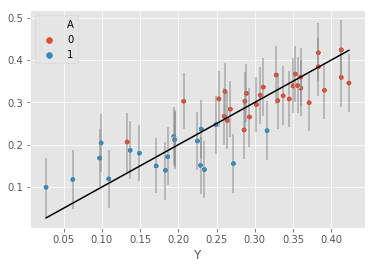

In [13]:
lower80, upper80 = mstats.mquantiles(sample_y_pred, [0.1, 0.9], axis=0)
sample_y_pred_mean = np.mean(sample_y_pred, axis=0)

sns.scatterplot(data['Y'], sample_y_pred_mean, data['A'])
lower_dist = sample_y_pred_mean - lower80
upper_dist = upper80 -  sample_y_pred_mean
plt.errorbar(data['Y'], sample_y_pred_mean, [lower_dist, upper_dist], ls='', alpha=0.6, color='gray')

x = [min(data['Y']), max(data['Y'])]
y = x
plt.plot(x, y, color='black')

(array([ 2.,  4.,  3.,  9., 10., 11.,  2.,  4.,  4.,  1.]),
 array([-0.10479587, -0.0826177 , -0.06043953, -0.03826135, -0.01608318,
         0.006095  ,  0.02827317,  0.05045135,  0.07262952,  0.0948077 ,
         0.11698587]),
 <a list of 10 Patch objects>)

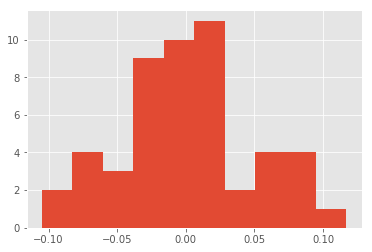

In [14]:
noise = data['Y'] - (np.mean(sample_b1) + np.mean(sample_b2) * data['A'] + np.mean(sample_b3) * data['Score'] / 200)
plt.hist(noise)

(array([ 2.,  4.,  3.,  9., 10., 11.,  2.,  4.,  4.,  1.]),
 array([-0.10479587, -0.0826177 , -0.06043953, -0.03826135, -0.01608318,
         0.006095  ,  0.02827317,  0.05045135,  0.07262952,  0.0948077 ,
         0.11698587]),
 <a list of 10 Patch objects>)

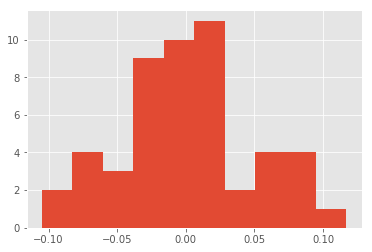

In [15]:
plt.hist(np.mean(-(sample_mu - np.array(data['Y'])), axis=0))

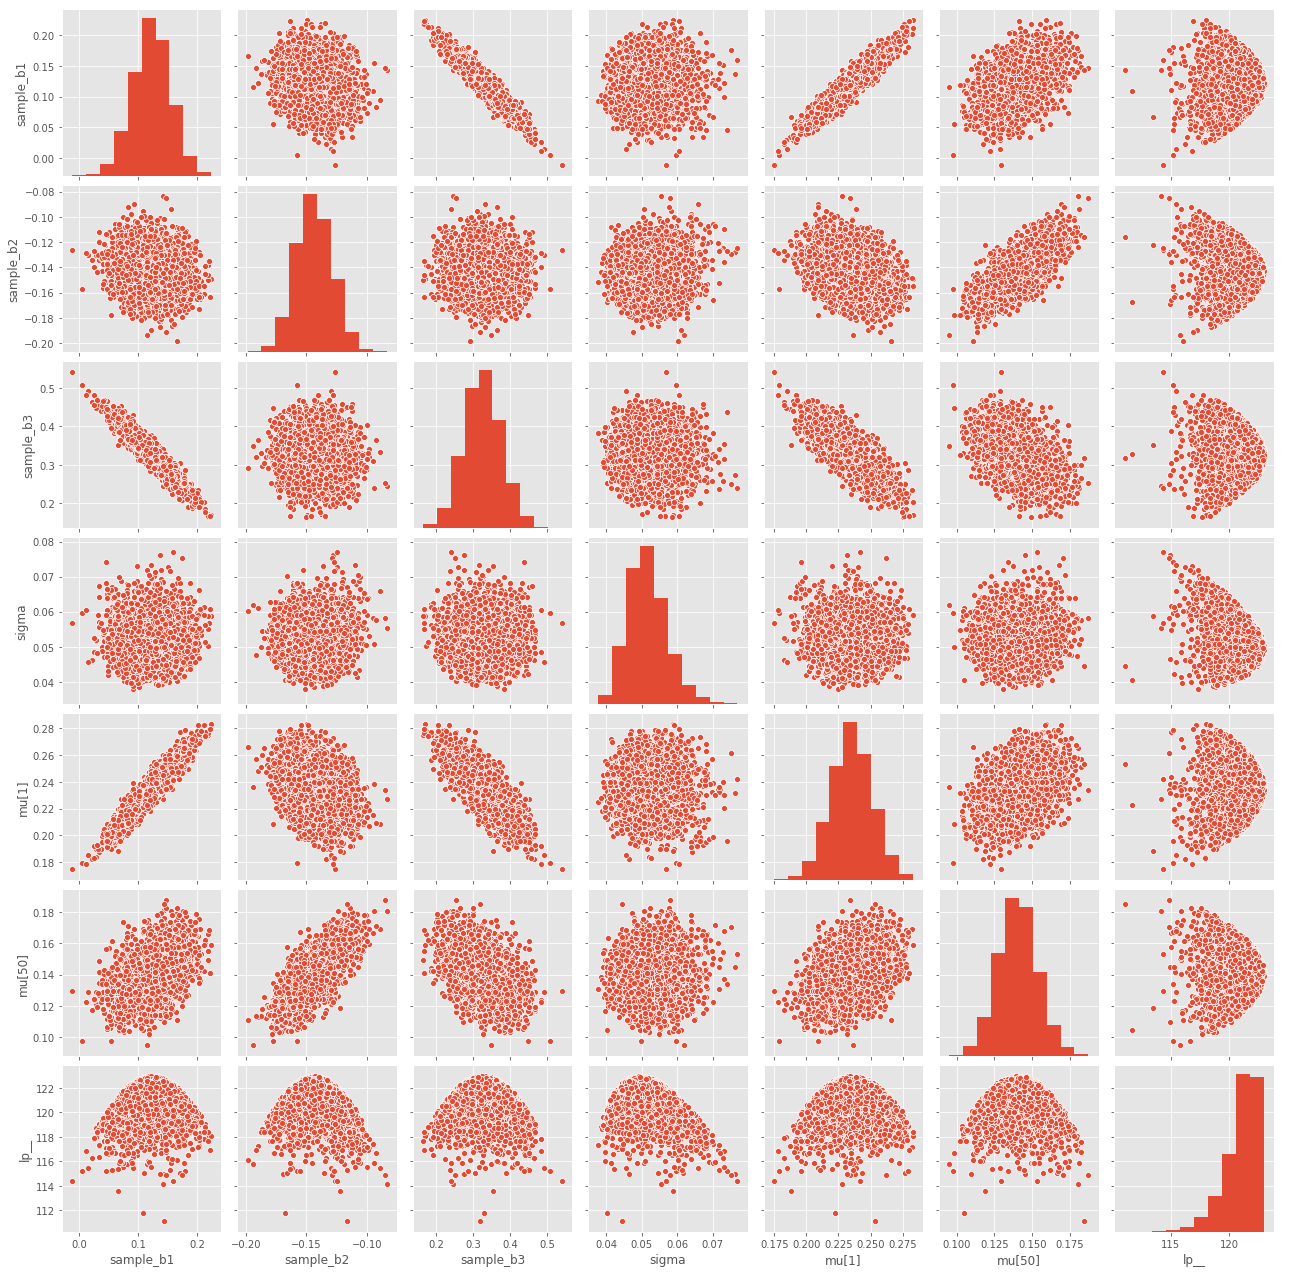

In [16]:
sample_df = pd.DataFrame([])
sample_df['sample_b1'] = sample_b1
sample_df['sample_b2'] = sample_b2
sample_df['sample_b3'] = sample_b3
sample_df['sigma'] = sample_sigma
sample_df['mu[1]'] = sample_mu[:,0]
sample_df['mu[50]'] = sample_mu[:,49]
sample_df['lp__'] = sample_lp__
sns.pairplot(sample_df)